# Project Description: Customer Segmentation for Promotional Strategies to Prevent Churn

#### Objective:
The primary objective of this project is to segment our customer base using clustering techniques to identify distinct groups of customers. By understanding the characteristics of these segments, we aim to develop targeted promotional strategies that will help prevent customer churn.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [6]:
df = pd.read_csv('/kaggle/input/churn-modelling/Churn_Modelling.csv')

### Data Preprocessing

In [7]:
# Simplifying column names and bringing consistency
df.columns = [name.lower() for name in list(df.columns)]
df.drop(['rownumber','customerid','surname'],axis=1,inplace=True)
df.rename(columns={"exited": "churn"}, inplace=True)


In [8]:
# Select only the churn customer
df_churn = df[df['churn']==1]

In [9]:
df_churn.head()

,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,churn
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
5,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1
7,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1
16,653,Germany,Male,58,1,132602.88,1,1,0,5097.67,1


#### Transforming

In [10]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [11]:
# Define the columns
numerical = ['creditscore', 'age', 'tenure','balance', 'estimatedsalary', 'numofproducts', 'hascrcard', 'isactivemember']
categorical = ['geography', 'gender']

# Define the column transformer to encode the categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical)
    ], remainder='passthrough')  # Passthrough numerical columns for now

# Define a pipeline to first apply the preprocessor and then scale all features
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler())  
])

# Fit the pipeline on the data and transform it
X = df_churn.drop('churn', axis=1)
y = df_churn['churn']
X_transformed = pipeline.fit_transform(X)

# Extract feature names after encoding
encoded_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical)
all_feature_names = list(encoded_feature_names) + numerical

# Convert the transformed data back to a DataFrame
df_preprocessed = pd.DataFrame(X_transformed, columns=all_feature_names)

## K Means

In [14]:
df_preprocessed.head()

,geography_Germany,geography_Spain,gender_Male,creditscore,age,tenure,balance,estimatedsalary,numofproducts,hascrcard,isactivemember
0,-0.815829,-0.504292,-0.887925,-0.262735,-0.290803,-0.999100,-1.561509,-0.593029,0.656108,1.330950,-0.002017
1,-0.815829,-0.504292,-0.887925,-1.429272,-0.290803,1.044924,1.174917,1.902841,0.656108,-0.751343,0.215307
2,-0.815829,1.982978,1.126221,-0.003505,-0.085868,1.044924,0.388151,0.654906,0.656108,-0.751343,0.834068
3,1.225748,-0.504292,-0.887925,-2.685542,-1.622884,-0.317759,0.410277,3.150776,0.656108,-0.751343,0.308839
4,1.225748,-0.504292,1.126221,0.076259,1.348681,-1.339771,0.711171,-0.593029,0.656108,-0.751343,-1.664439


In [15]:
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans

In [16]:
sse = []  # Sum of Squared Errors
cluster_range = range(1, 11)  # Adjust the range if needed

for num_clusters in cluster_range:
    kmeans = KMeans(n_clusters=num_clusters, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(df_preprocessed)
    sse.append(kmeans.inertia_)  # kmeans.inertia_ gives the SSE/WCSS

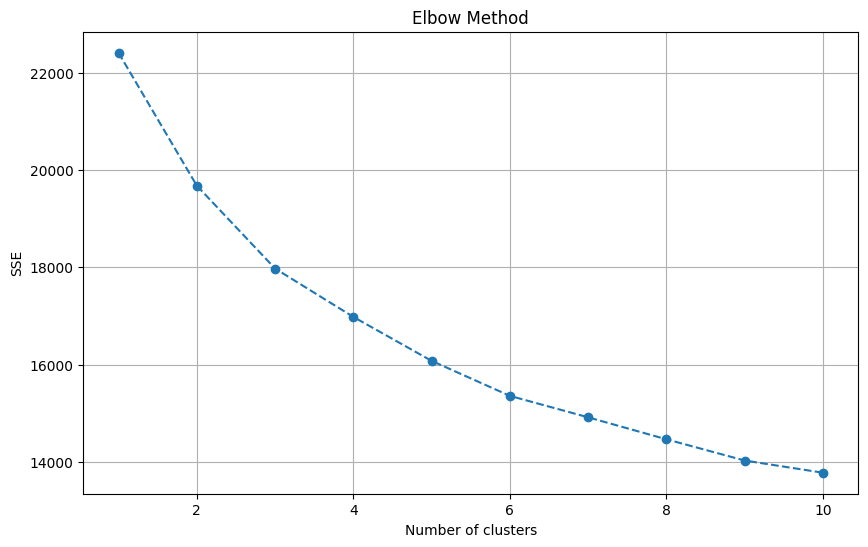

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, sse, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.grid(True)
plt.show()


For n_clusters = 2, the average silhouette_score is: 0.11823576065787533


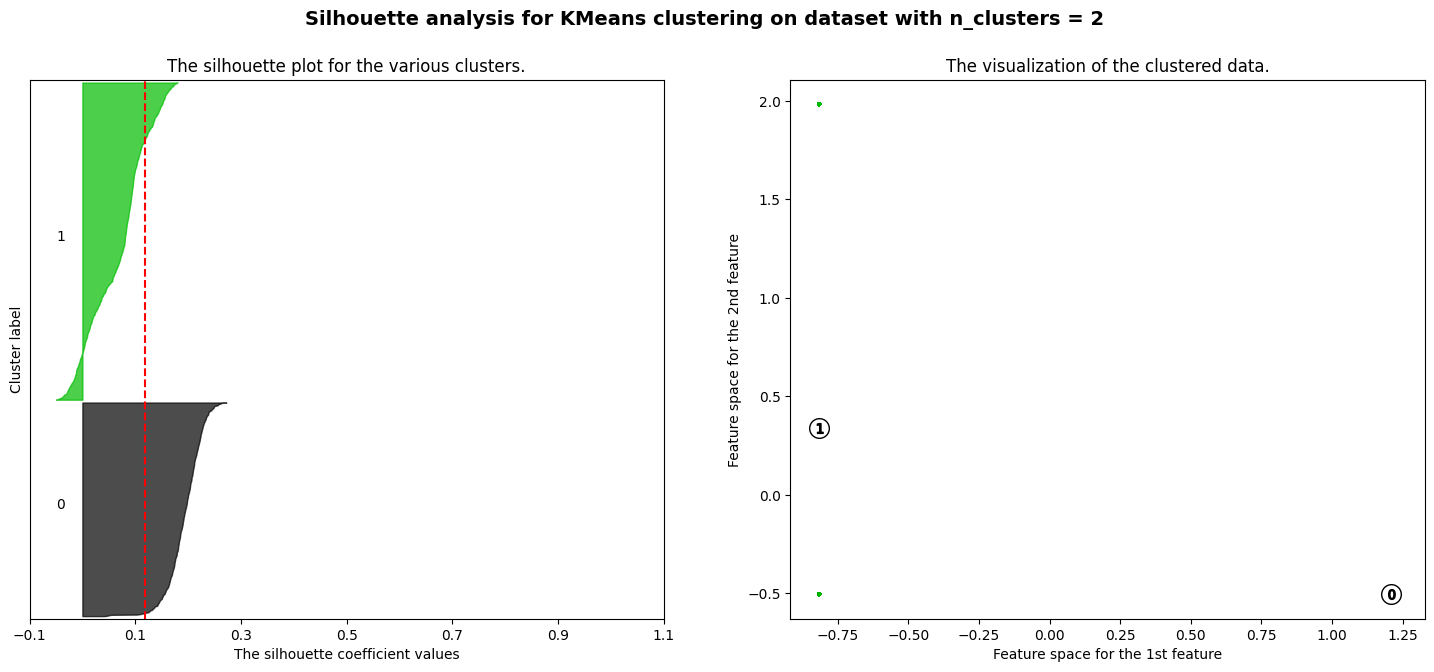

For n_clusters = 3, the average silhouette_score is: 0.12990840647834276


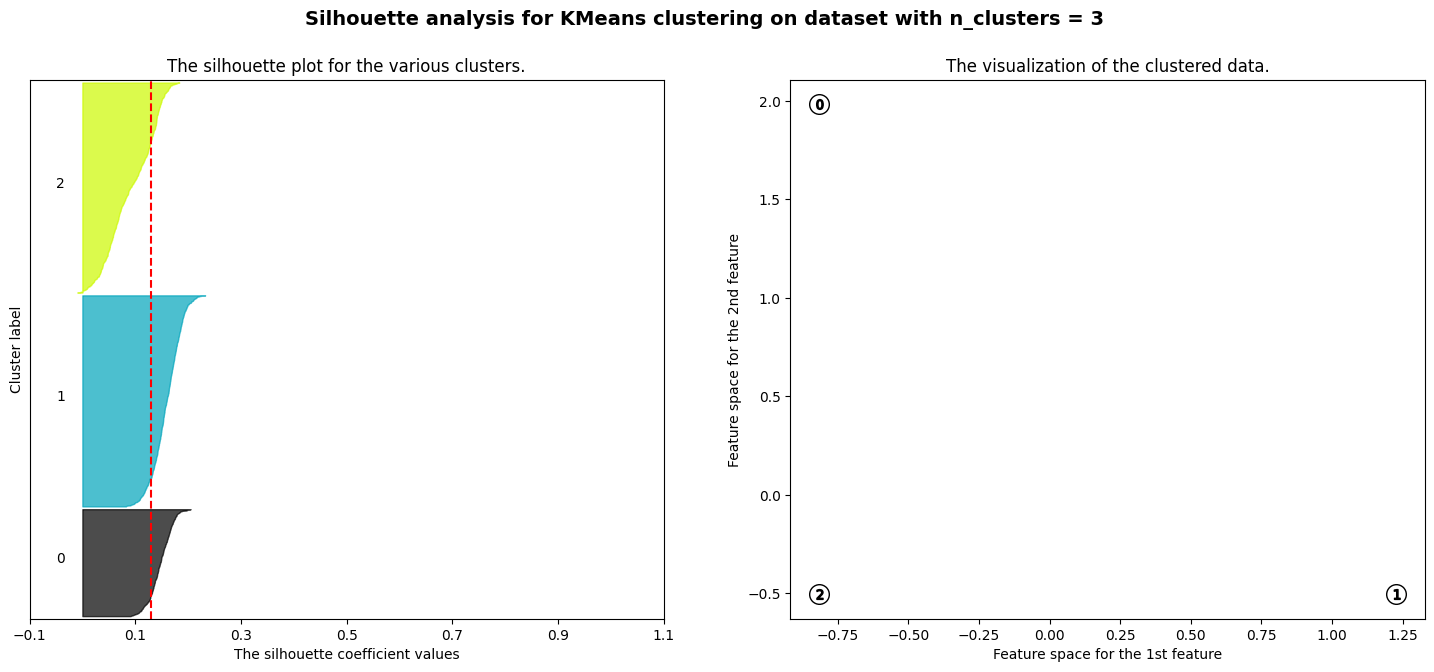

For n_clusters = 4, the average silhouette_score is: 0.11581088738238589


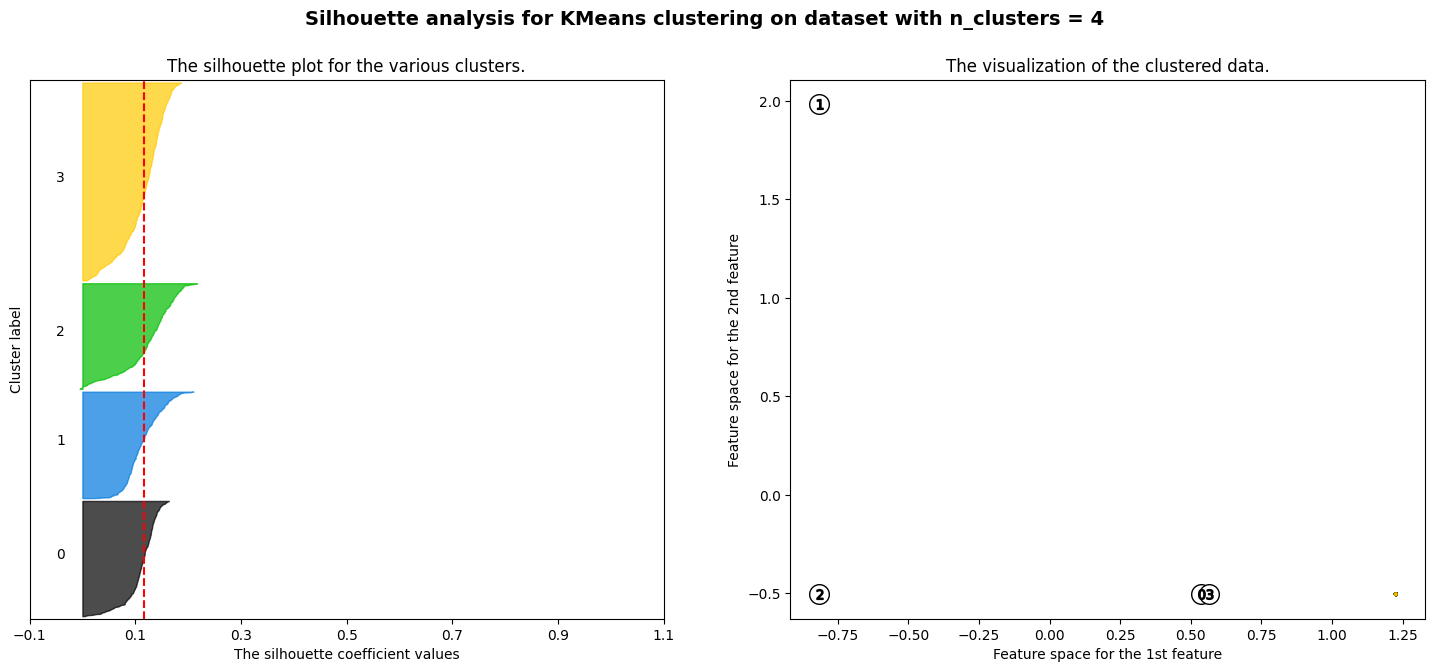

For n_clusters = 5, the average silhouette_score is: 0.11461457479673882


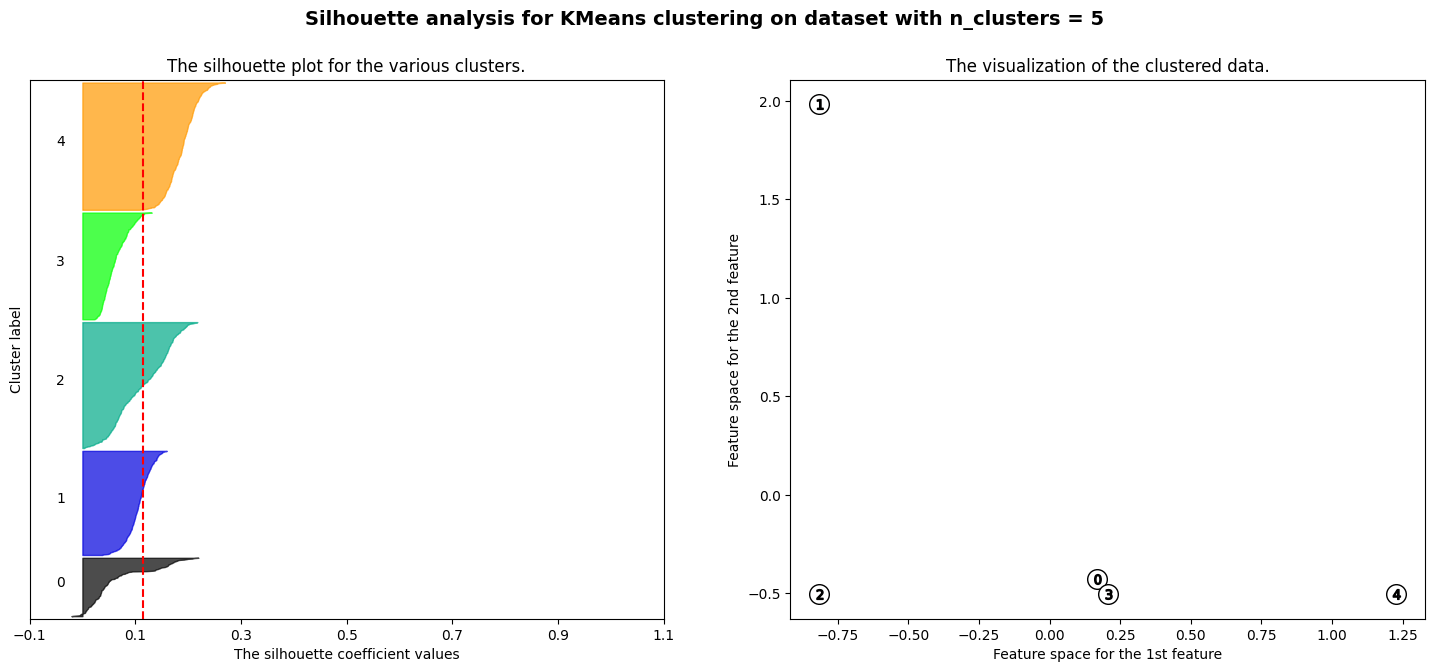

For n_clusters = 6, the average silhouette_score is: 0.10362342163981007


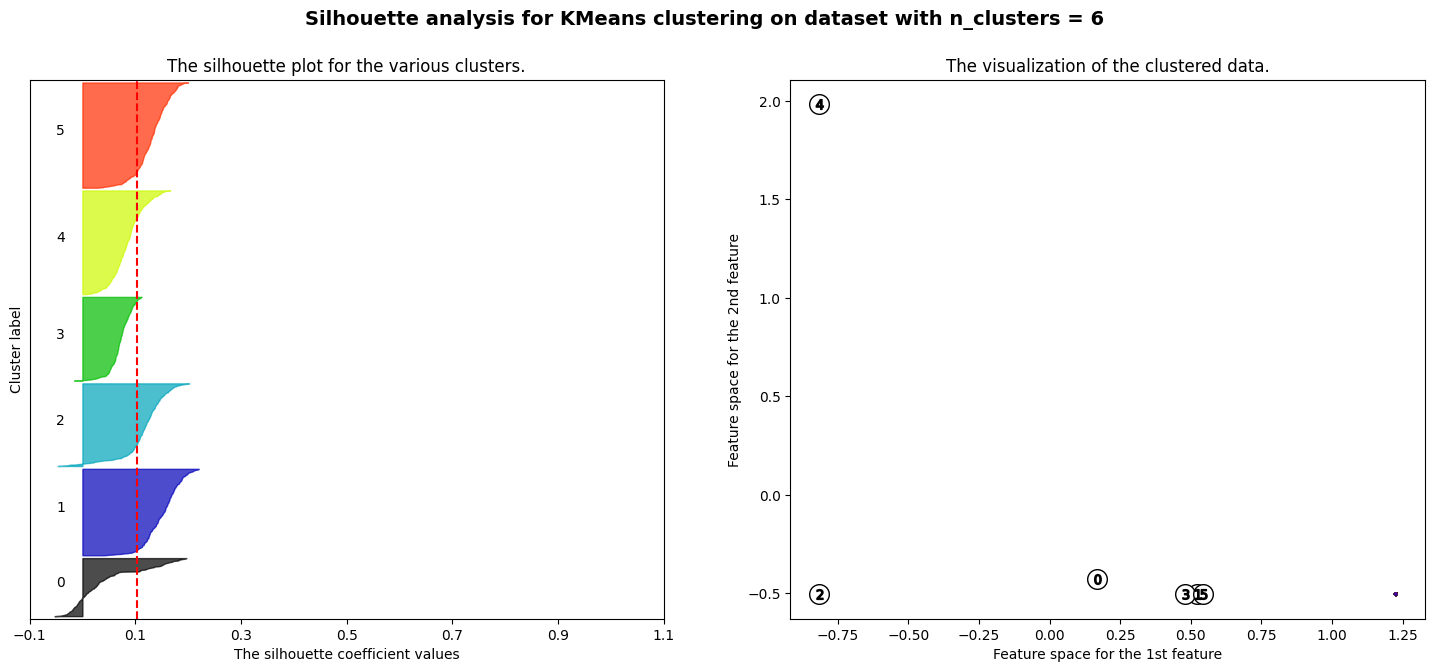

In [18]:
import matplotlib.cm as cm

X = df_preprocessed.values

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator seed for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(f"For n_clusters = {n_clusters}, the average silhouette_score is: {silhouette_avg}")

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks(np.arange(-0.1, 1.1, 0.2))

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k")

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker="o", c="white", alpha=1, s=200, edgecolor="k")

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        f"Silhouette analysis for KMeans clustering on dataset with n_clusters = {n_clusters}",
        fontsize=14,
        fontweight="bold",
    )

    plt.show()

Choosing the optimal number of clusters using the elbow method can be challenging when the plot does not clearly flatten out. In such cases, using silhouette analysis to determine the number of clusters may be more effective, and based on this analysis, selecting three clusters would be appropriate.

In [45]:
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42,n_init=10)
kmeans_model = kmeans.fit(df_preprocessed)

cluster_labels = kmeans_model.predict(df_preprocessed)

In [46]:
df_churn_original = df[df['churn']==1]
df_churn_original['cluster'] = cluster_labels

/tmp/ipykernel_33/1914590516.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [47]:
df_churn_original['cluster'].value_counts()

cluster
1    814
2    810
0    413
Name: count, dtype: int64

In [50]:
import seaborn as sns

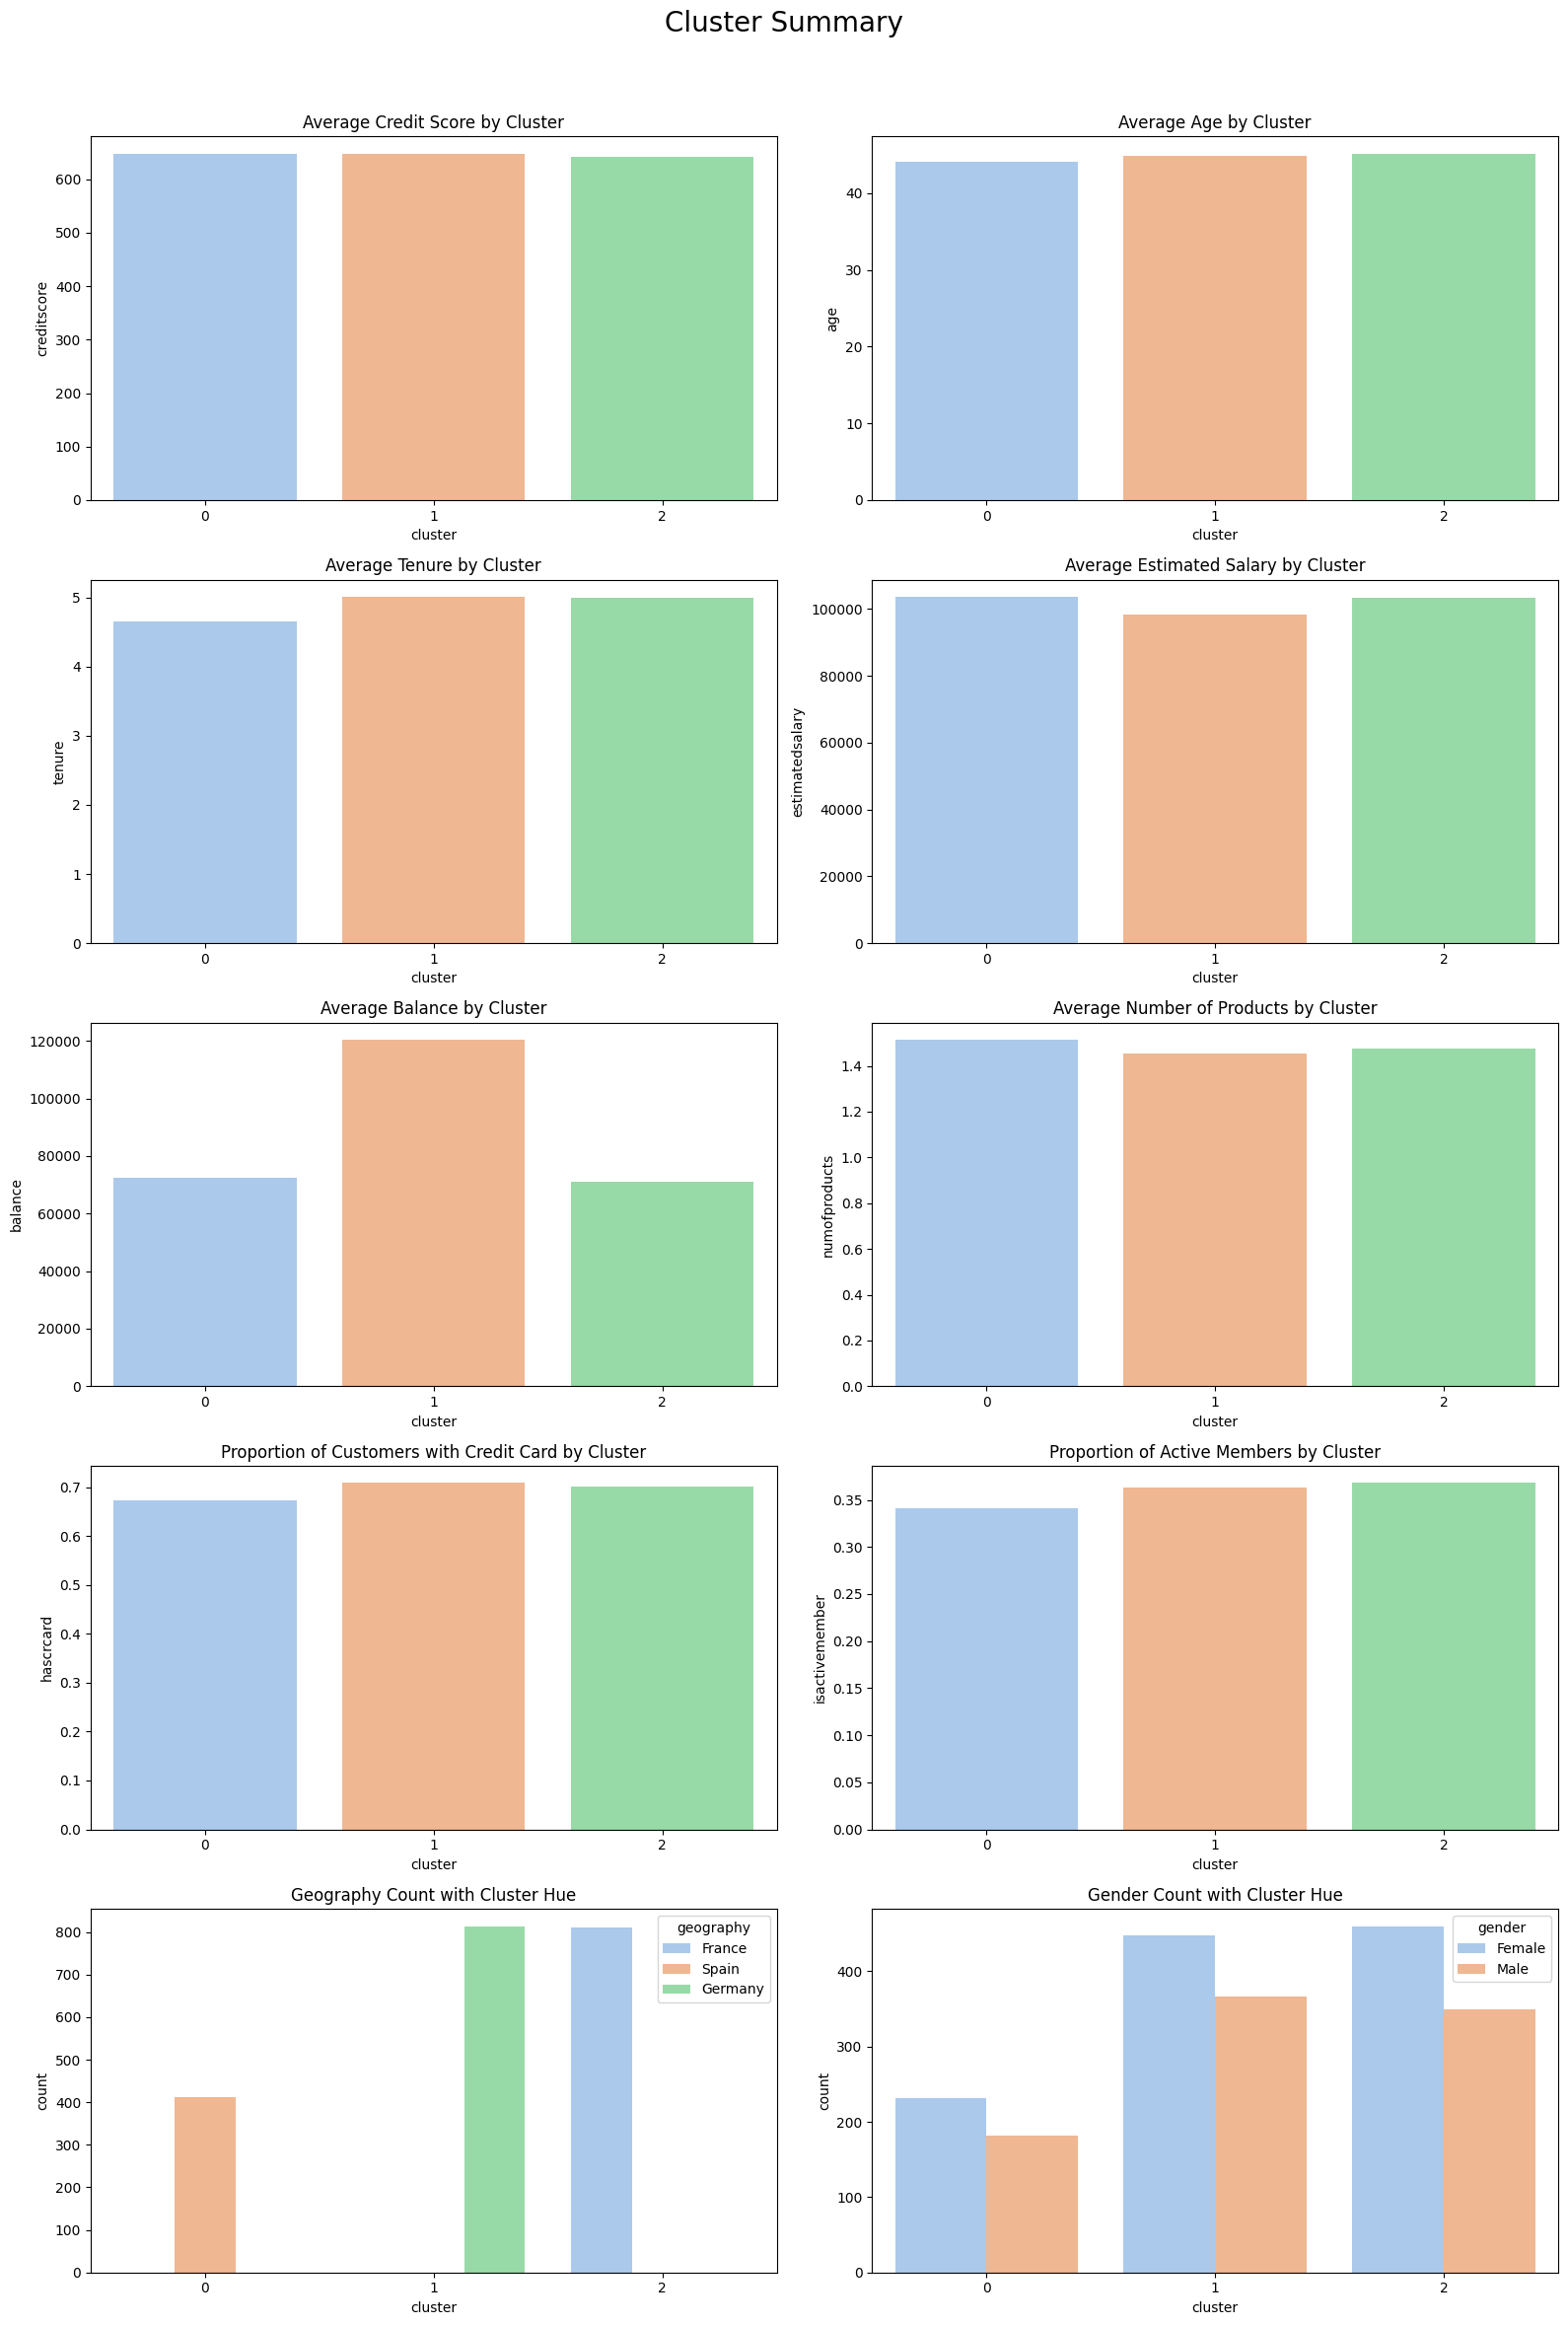

In [51]:
# Create a summary of the clusters
cluster_summary = df_churn_original.groupby('cluster').agg({
    'creditscore': 'mean',
    'age': 'mean',
    'tenure': 'mean',
    'balance': 'mean',
    'estimatedsalary': 'mean',
    'numofproducts': 'mean',
    'hascrcard': 'mean',
    'isactivemember': 'mean'
}).reset_index()

# Set up the figure with subplots
fig, axs = plt.subplots(5, 2, figsize=(16, 24))
fig.suptitle('Cluster Summary', fontsize=20)

# Creditscore by Cluster
sns.barplot(x='cluster', y='creditscore', data=cluster_summary, ax=axs[0, 0], palette='pastel')
axs[0, 0].set_title('Average Credit Score by Cluster')

# Age by Cluster
sns.barplot(x='cluster', y='age', data=cluster_summary, ax=axs[0, 1], palette='pastel')
axs[0, 1].set_title('Average Age by Cluster')

# Tenure by Cluster
sns.barplot(x='cluster', y='tenure', data=cluster_summary, ax=axs[1, 0], palette='pastel')
axs[1, 0].set_title('Average Tenure by Cluster')

# Estimated Salary by Cluster
sns.barplot(x='cluster', y='estimatedsalary', data=cluster_summary, ax=axs[1, 1], palette='pastel')
axs[1, 1].set_title('Average Estimated Salary by Cluster')

# Balance by Cluster
sns.barplot(x='cluster', y='balance', data=cluster_summary, ax=axs[2, 0], palette='pastel')
axs[2, 0].set_title('Average Balance by Cluster')

# Number of Products by Cluster
sns.barplot(x='cluster', y='numofproducts', data=cluster_summary, ax=axs[2, 1], palette='pastel')
axs[2, 1].set_title('Average Number of Products by Cluster')

# Has Credit Card by Cluster
sns.barplot(x='cluster', y='hascrcard', data=cluster_summary, ax=axs[3, 0], palette='pastel')
axs[3, 0].set_title('Proportion of Customers with Credit Card by Cluster')

# Is Active Member by Cluster
sns.barplot(x='cluster', y='isactivemember', data=cluster_summary, ax=axs[3, 1], palette='pastel')
axs[3, 1].set_title('Proportion of Active Members by Cluster')

# Geography Count with Cluster Hue
sns.countplot(data=df_churn_original, x='cluster', hue='geography', ax=axs[4, 0], palette='pastel')
axs[4, 0].set_title('Geography Count with Cluster Hue')

# Gender Count with Cluster Hue
sns.countplot(data=df_churn_original, x='cluster', hue='gender', ax=axs[4, 1], palette='pastel')
axs[4, 1].set_title('Gender Count with Cluster Hue')

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Using K-Means, I believe there is no significant clustering evident based on the summary of the clusters. Therefore, I will attempt another clustering method.

## DBScan

In [34]:
from sklearn.cluster import DBSCAN
# Applying DBSCAN
dbscan = DBSCAN(eps=0.3, min_samples=5)  # you may need to adjust these parameters
clusters = dbscan.fit_predict(df_preprocessed)

# Adding the cluster labels to the original data
df_churn_original['cluster'] = clusters


/tmp/ipykernel_33/2003871168.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [35]:
df_preprocessed

,geography_Germany,geography_Spain,gender_Male,creditscore,age,tenure,balance,estimatedsalary,numofproducts,hascrcard,isactivemember
0,-0.815829,-0.504292,-0.887925,-0.262735,-0.290803,-0.999100,-1.561509,-0.593029,0.656108,1.330950,-0.002017
1,-0.815829,-0.504292,-0.887925,-1.429272,-0.290803,1.044924,1.174917,1.902841,0.656108,-0.751343,0.215307
2,-0.815829,1.982978,1.126221,-0.003505,-0.085868,1.044924,0.388151,0.654906,0.656108,-0.751343,0.834068
3,1.225748,-0.504292,-0.887925,-2.685542,-1.622884,-0.317759,0.410277,3.150776,0.656108,-0.751343,0.308839
4,1.225748,-0.504292,1.126221,0.076259,1.348681,-1.339771,0.711171,-0.593029,0.656108,-0.751343,-1.664439
...,...,...,...,...,...,...,...,...,...,...,...
2032,1.225748,-0.504292,1.126221,-1.469153,-0.290803,-0.658429,1.044299,-0.593029,0.656108,1.330950,-0.829395
2033,1.225748,-0.504292,-0.887925,0.096199,0.119068,0.704254,0.789021,-0.593029,0.656108,-0.751343,0.236289
2034,-0.815829,-0.504292,-0.887925,-0.482084,0.836342,-0.317759,-0.046744,-0.593029,0.656108,-0.751343,-0.554093
2035,-0.815829,-0.504292,-0.887925,0.634601,-0.905610,0.704254,-1.561509,-0.593029,-1.524140,1.330950,-1.025595


In [36]:
df_churn_original

,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,churn,cluster
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,-1
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,-1
5,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1,-1
7,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1,-1
16,653,Germany,Male,58,1,132602.88,1,1,0,5097.67,1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...
9981,498,Germany,Male,42,3,152039.70,1,1,1,53445.17,1,-1
9982,655,Germany,Female,46,7,137145.12,1,1,0,115146.40,1,-1
9991,597,France,Female,53,4,88381.21,1,1,0,69384.71,1,-1
9997,709,France,Female,36,7,0.00,1,0,1,42085.58,1,-1


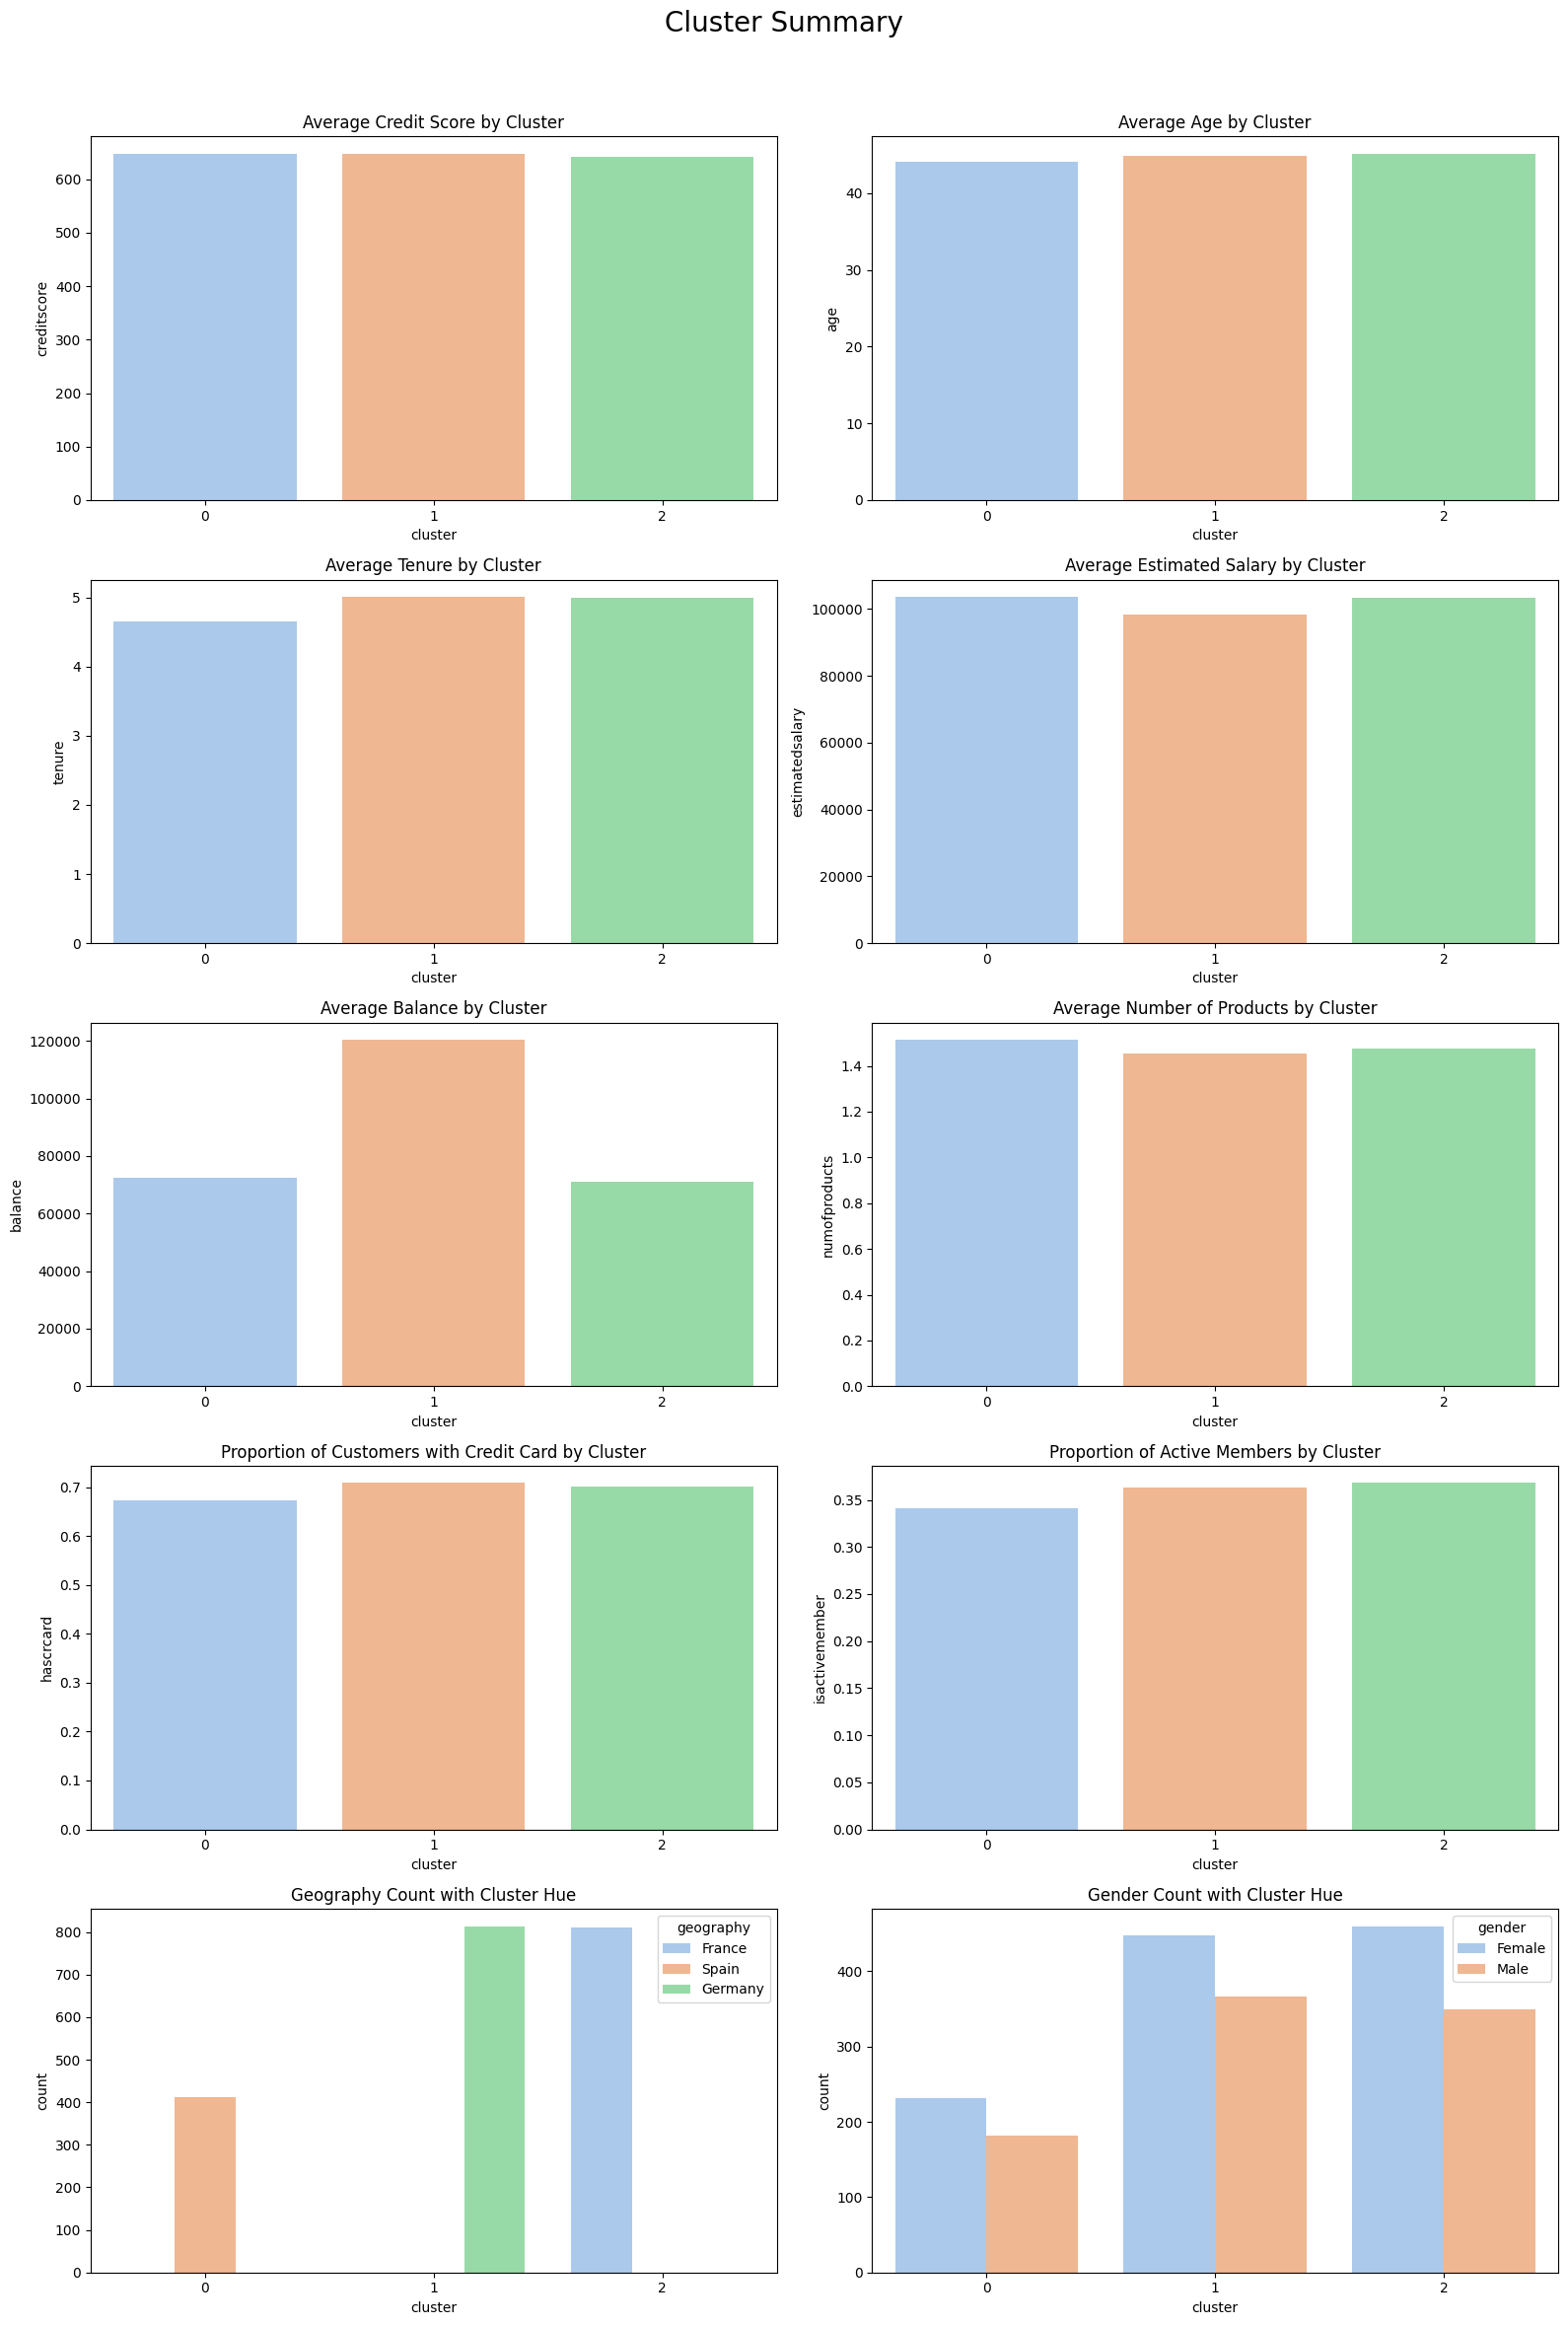

In [52]:
# Create a summary of the clusters
cluster_summary = df_churn_original.groupby('cluster').agg({
    'creditscore': 'mean',
    'age': 'mean',
    'tenure': 'mean',
    'balance': 'mean',
    'estimatedsalary': 'mean',
    'numofproducts': 'mean',
    'hascrcard': 'mean',
    'isactivemember': 'mean'
}).reset_index()

# Set up the figure with subplots
fig, axs = plt.subplots(5, 2, figsize=(16, 24))
fig.suptitle('Cluster Summary', fontsize=20)

# Creditscore by Cluster
sns.barplot(x='cluster', y='creditscore', data=cluster_summary, ax=axs[0, 0], palette='pastel')
axs[0, 0].set_title('Average Credit Score by Cluster')

# Age by Cluster
sns.barplot(x='cluster', y='age', data=cluster_summary, ax=axs[0, 1], palette='pastel')
axs[0, 1].set_title('Average Age by Cluster')

# Tenure by Cluster
sns.barplot(x='cluster', y='tenure', data=cluster_summary, ax=axs[1, 0], palette='pastel')
axs[1, 0].set_title('Average Tenure by Cluster')

# Estimated Salary by Cluster
sns.barplot(x='cluster', y='estimatedsalary', data=cluster_summary, ax=axs[1, 1], palette='pastel')
axs[1, 1].set_title('Average Estimated Salary by Cluster')

# Balance by Cluster
sns.barplot(x='cluster', y='balance', data=cluster_summary, ax=axs[2, 0], palette='pastel')
axs[2, 0].set_title('Average Balance by Cluster')

# Number of Products by Cluster
sns.barplot(x='cluster', y='numofproducts', data=cluster_summary, ax=axs[2, 1], palette='pastel')
axs[2, 1].set_title('Average Number of Products by Cluster')

# Has Credit Card by Cluster
sns.barplot(x='cluster', y='hascrcard', data=cluster_summary, ax=axs[3, 0], palette='pastel')
axs[3, 0].set_title('Proportion of Customers with Credit Card by Cluster')

# Is Active Member by Cluster
sns.barplot(x='cluster', y='isactivemember', data=cluster_summary, ax=axs[3, 1], palette='pastel')
axs[3, 1].set_title('Proportion of Active Members by Cluster')

# Geography Count with Cluster Hue
sns.countplot(data=df_churn_original, x='cluster', hue='geography', ax=axs[4, 0], palette='pastel')
axs[4, 0].set_title('Geography Count with Cluster Hue')

# Gender Count with Cluster Hue
sns.countplot(data=df_churn_original, x='cluster', hue='gender', ax=axs[4, 1], palette='pastel')
axs[4, 1].set_title('Gender Count with Cluster Hue')

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Using DBSCAN, it treats most of the data points as noise, assigning them a value of -1. Therefore, we will try another clustering method.

## Gaussian Mixture

In [120]:
from sklearn.mixture import GaussianMixture

# 3 of clusters
k = 4 # Adjust based on your data

# Applying GMM
gmm = GaussianMixture(n_components=k, random_state=42)
clusters = gmm.fit_predict(df_preprocessed)

# Adding the cluster labels to the original data
df_churn_original['cluster'] = clusters

# Checking the resulting clusters
print(df_churn_original['cluster'].value_counts())


cluster
3    810
1    486
0    413
2    328
Name: count, dtype: int64


/tmp/ipykernel_33/1065604166.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



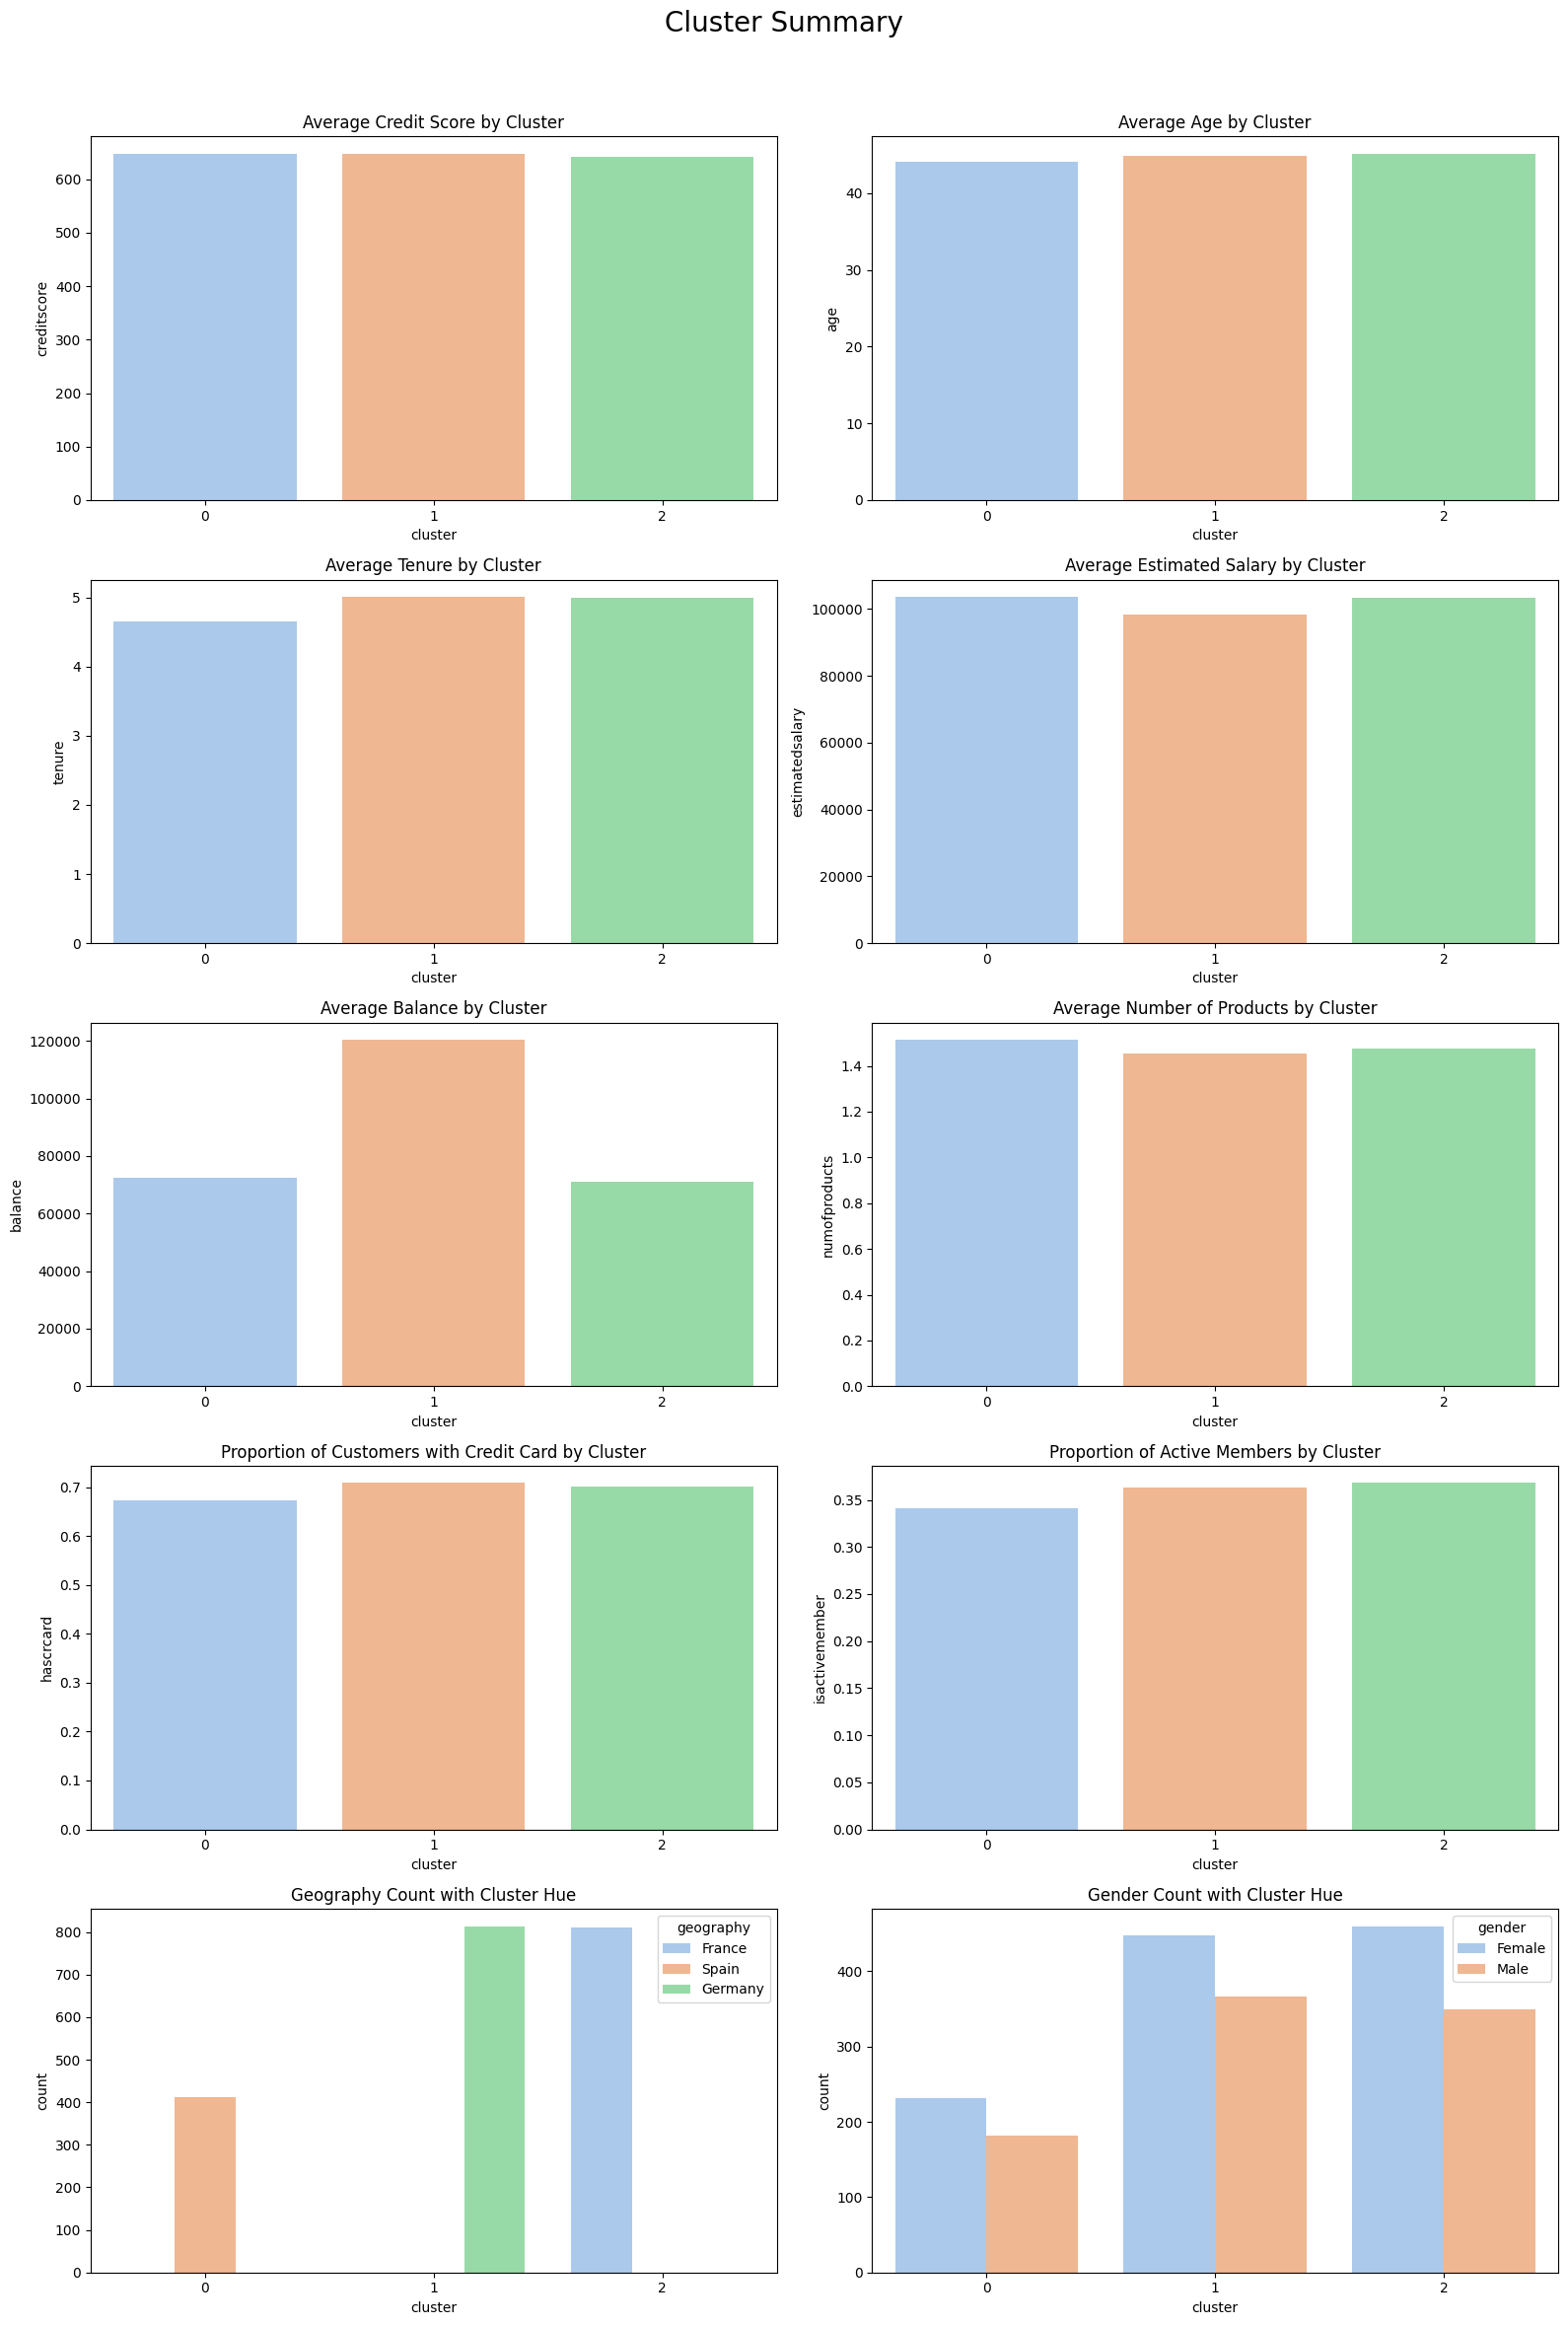

In [53]:
# Create a summary of the clusters
cluster_summary = df_churn_original.groupby('cluster').agg({
    'creditscore': 'mean',
    'age': 'mean',
    'tenure': 'mean',
    'balance': 'mean',
    'estimatedsalary': 'mean',
    'numofproducts': 'mean',
    'hascrcard': 'mean',
    'isactivemember': 'mean'
}).reset_index()

# Set up the figure with subplots
fig, axs = plt.subplots(5, 2, figsize=(16, 24))
fig.suptitle('Cluster Summary', fontsize=20)

# Creditscore by Cluster
sns.barplot(x='cluster', y='creditscore', data=cluster_summary, ax=axs[0, 0], palette='pastel')
axs[0, 0].set_title('Average Credit Score by Cluster')

# Age by Cluster
sns.barplot(x='cluster', y='age', data=cluster_summary, ax=axs[0, 1], palette='pastel')
axs[0, 1].set_title('Average Age by Cluster')

# Tenure by Cluster
sns.barplot(x='cluster', y='tenure', data=cluster_summary, ax=axs[1, 0], palette='pastel')
axs[1, 0].set_title('Average Tenure by Cluster')

# Estimated Salary by Cluster
sns.barplot(x='cluster', y='estimatedsalary', data=cluster_summary, ax=axs[1, 1], palette='pastel')
axs[1, 1].set_title('Average Estimated Salary by Cluster')

# Balance by Cluster
sns.barplot(x='cluster', y='balance', data=cluster_summary, ax=axs[2, 0], palette='pastel')
axs[2, 0].set_title('Average Balance by Cluster')

# Number of Products by Cluster
sns.barplot(x='cluster', y='numofproducts', data=cluster_summary, ax=axs[2, 1], palette='pastel')
axs[2, 1].set_title('Average Number of Products by Cluster')

# Has Credit Card by Cluster
sns.barplot(x='cluster', y='hascrcard', data=cluster_summary, ax=axs[3, 0], palette='pastel')
axs[3, 0].set_title('Proportion of Customers with Credit Card by Cluster')

# Is Active Member by Cluster
sns.barplot(x='cluster', y='isactivemember', data=cluster_summary, ax=axs[3, 1], palette='pastel')
axs[3, 1].set_title('Proportion of Active Members by Cluster')

# Geography Count with Cluster Hue
sns.countplot(data=df_churn_original, x='cluster', hue='geography', ax=axs[4, 0], palette='pastel')
axs[4, 0].set_title('Geography Count with Cluster Hue')

# Gender Count with Cluster Hue
sns.countplot(data=df_churn_original, x='cluster', hue='gender', ax=axs[4, 1], palette='pastel')
axs[4, 1].set_title('Gender Count with Cluster Hue')

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Cluster 0
- Spain
- Low Salary
- Low Balance

Cluster 1
- Germany
- Medium Salary
- High Balance

Cluster 2
- Germany
- High Salary
- High Balance

Cluster 3
- France
- Low Salary
- Low Balance

I believe my data has high dimensionality, which makes clustering challenging. Therefore, I will filter out features that are not important for clustering and then attempt clustering again.

In [125]:
# Select only the churn customer
df_churn = df[df['churn']==1]

In [151]:
# Select only the churn customer
df_churn = df[df['churn']==1]
df_churn = df_churn.drop(['creditscore','hascrcard','isactivemember','numofproducts','estimatedsalary'],axis=1)

In [152]:
# Define the columns
numerical = [ 'age', 'tenure','balance']
categorical = ['geography', 'gender']

# Define the column transformer to encode the categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical)
    ], remainder='passthrough')  # Passthrough numerical columns for now

# Define a pipeline to first apply the preprocessor and then scale all features
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler())  # Scale all features (both encoded and numerical)
])

# Fit the pipeline on the data and transform it
X = df_churn.drop('churn', axis=1)
y = df_churn['churn']
X_transformed = pipeline.fit_transform(X)

# Extract feature names after encoding
encoded_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical)
all_feature_names = list(encoded_feature_names) + numerical

# Convert the transformed data back to a DataFrame
df_preprocessed = pd.DataFrame(X_transformed, columns=all_feature_names)

In [153]:
from sklearn.mixture import GaussianMixture

# 3 of clusters
k = 4 # Adjust based on your data

# Applying GMM
gmm = GaussianMixture(n_components=k, random_state=42)
clusters = gmm.fit_predict(df_preprocessed)

# Adding the cluster labels to the original data
df_churn_original['cluster'] = clusters

# Checking the resulting clusters
print(df_churn_original['cluster'].value_counts())


cluster
3    810
2    462
0    413
1    352
Name: count, dtype: int64


/tmp/ipykernel_33/1065604166.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



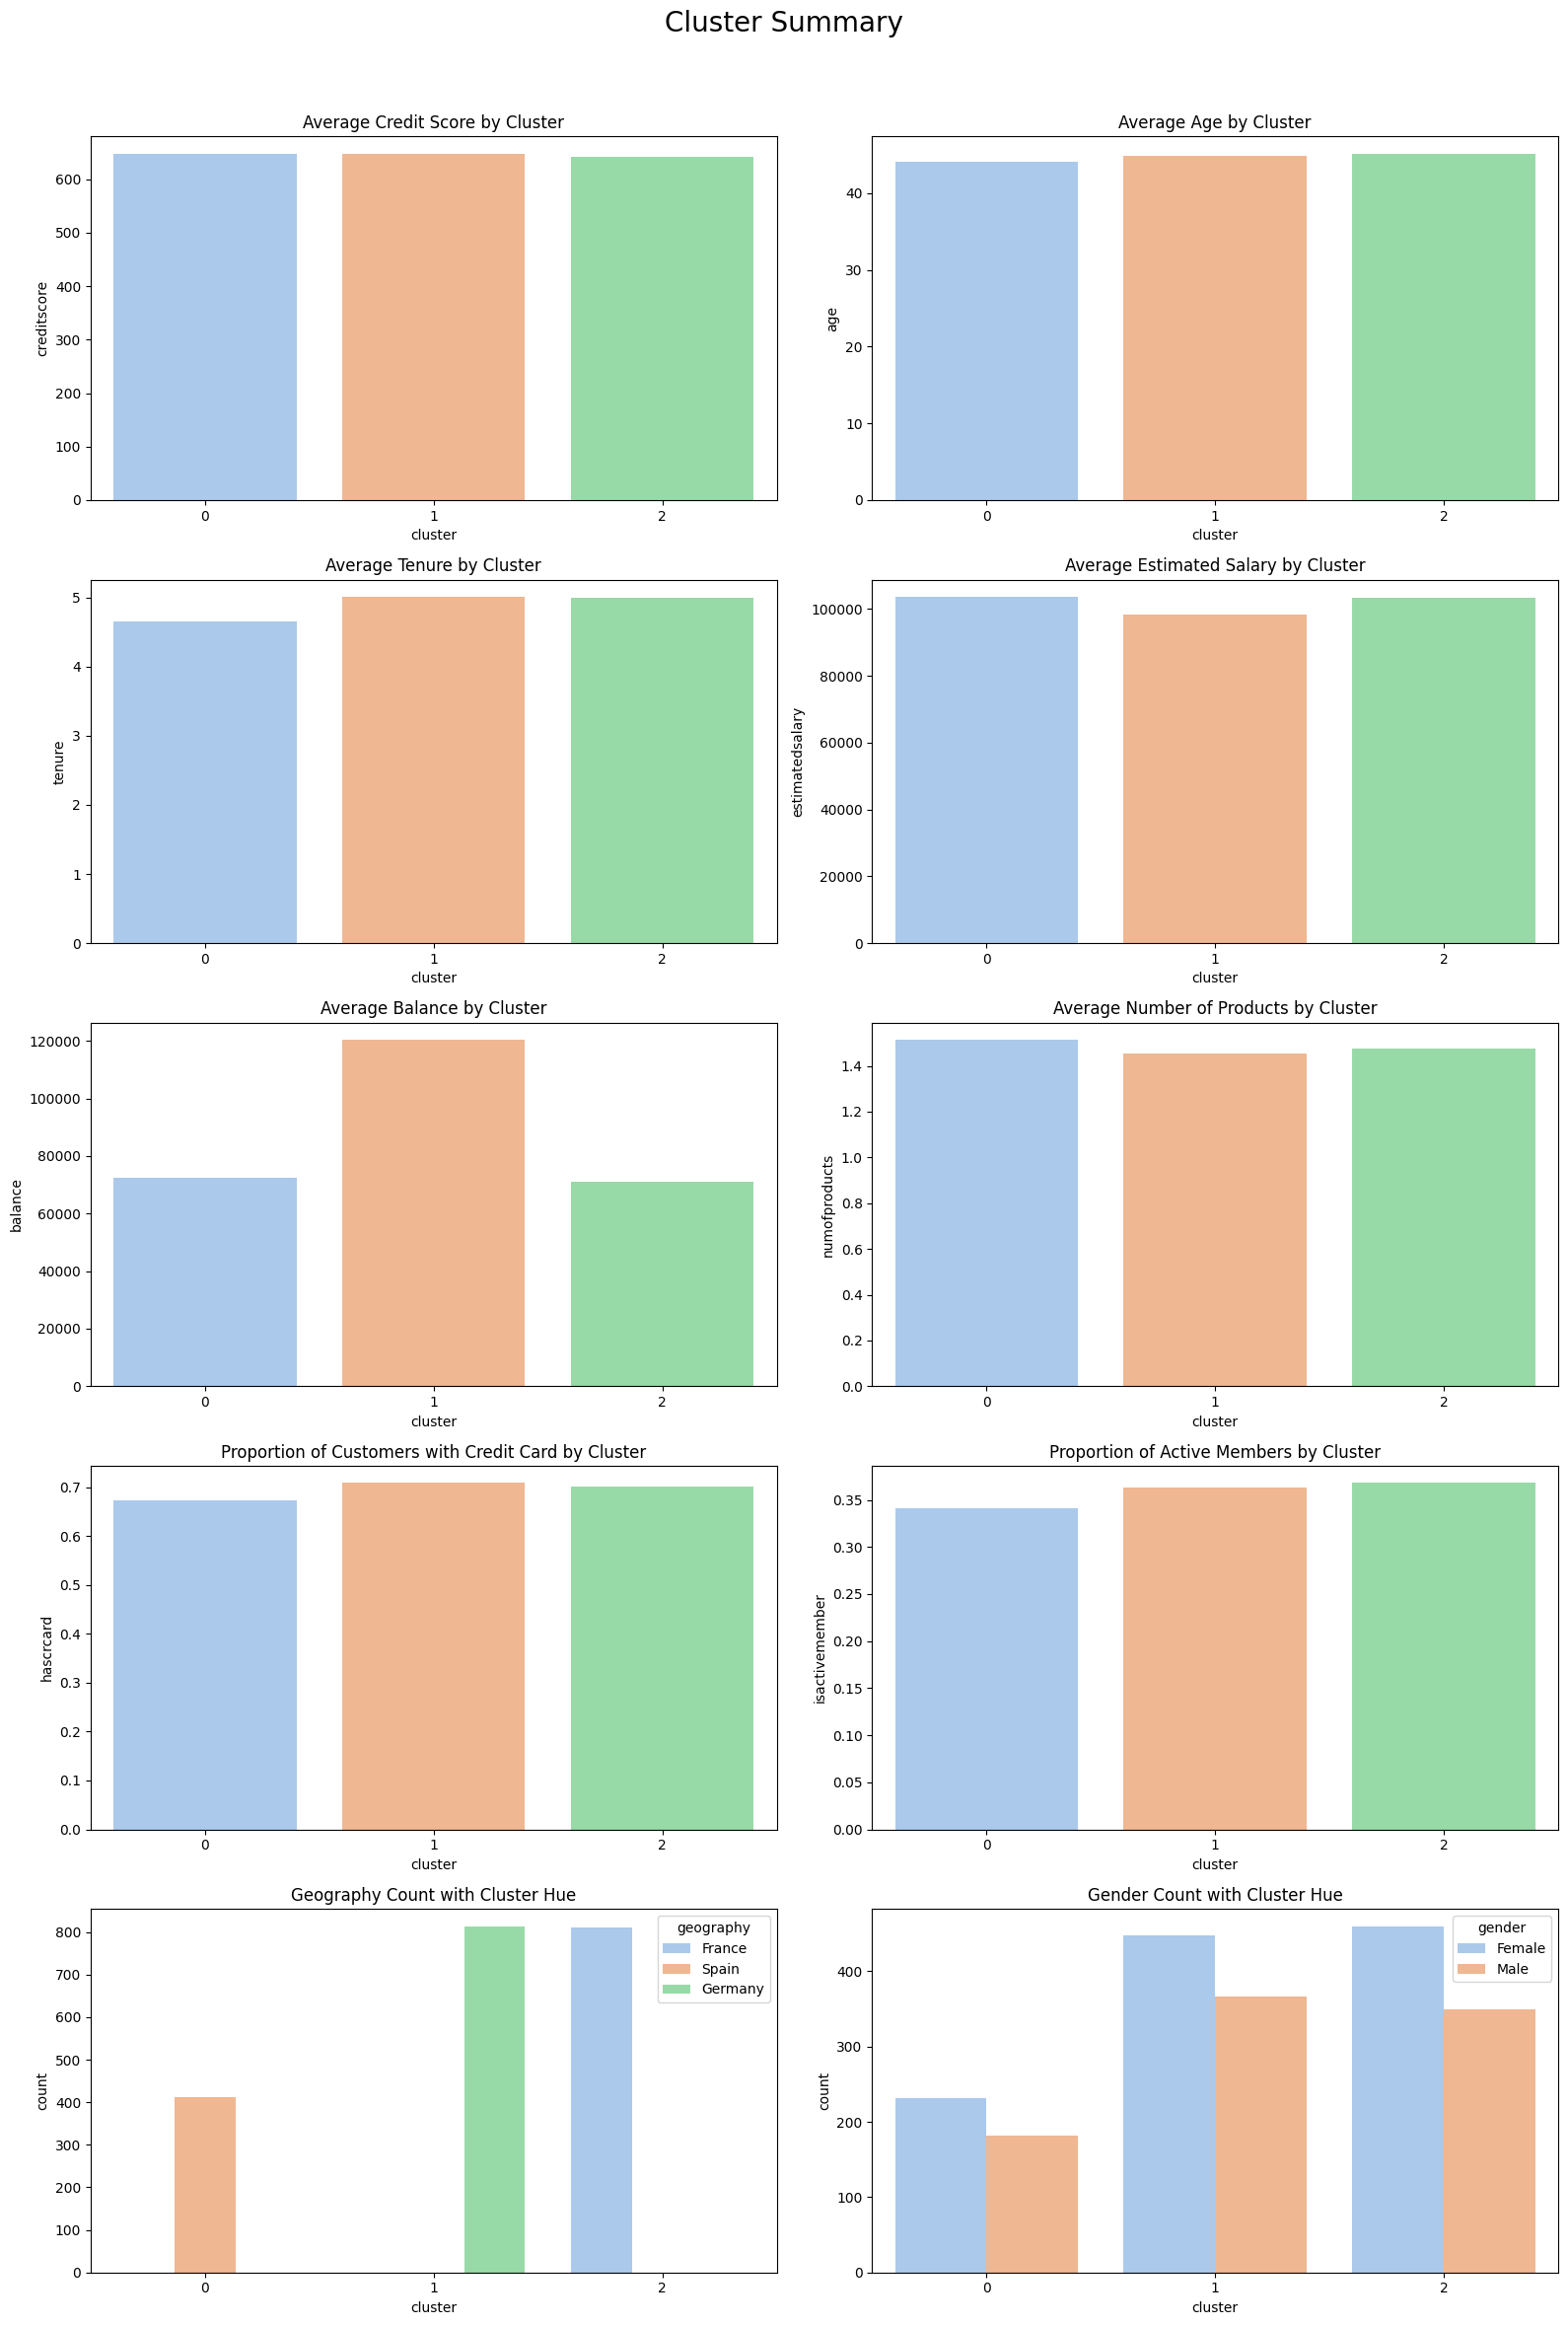

In [54]:
# Create a summary of the clusters
cluster_summary = df_churn_original.groupby('cluster').agg({
    'creditscore': 'mean',
    'age': 'mean',
    'tenure': 'mean',
    'balance': 'mean',
    'estimatedsalary': 'mean',
    'numofproducts': 'mean',
    'hascrcard': 'mean',
    'isactivemember': 'mean'
}).reset_index()

# Set up the figure with subplots
fig, axs = plt.subplots(5, 2, figsize=(16, 24))
fig.suptitle('Cluster Summary', fontsize=20)

# Creditscore by Cluster
sns.barplot(x='cluster', y='creditscore', data=cluster_summary, ax=axs[0, 0], palette='pastel')
axs[0, 0].set_title('Average Credit Score by Cluster')

# Age by Cluster
sns.barplot(x='cluster', y='age', data=cluster_summary, ax=axs[0, 1], palette='pastel')
axs[0, 1].set_title('Average Age by Cluster')

# Tenure by Cluster
sns.barplot(x='cluster', y='tenure', data=cluster_summary, ax=axs[1, 0], palette='pastel')
axs[1, 0].set_title('Average Tenure by Cluster')

# Estimated Salary by Cluster
sns.barplot(x='cluster', y='estimatedsalary', data=cluster_summary, ax=axs[1, 1], palette='pastel')
axs[1, 1].set_title('Average Estimated Salary by Cluster')

# Balance by Cluster
sns.barplot(x='cluster', y='balance', data=cluster_summary, ax=axs[2, 0], palette='pastel')
axs[2, 0].set_title('Average Balance by Cluster')

# Number of Products by Cluster
sns.barplot(x='cluster', y='numofproducts', data=cluster_summary, ax=axs[2, 1], palette='pastel')
axs[2, 1].set_title('Average Number of Products by Cluster')

# Has Credit Card by Cluster
sns.barplot(x='cluster', y='hascrcard', data=cluster_summary, ax=axs[3, 0], palette='pastel')
axs[3, 0].set_title('Proportion of Customers with Credit Card by Cluster')

# Is Active Member by Cluster
sns.barplot(x='cluster', y='isactivemember', data=cluster_summary, ax=axs[3, 1], palette='pastel')
axs[3, 1].set_title('Proportion of Active Members by Cluster')

# Geography Count with Cluster Hue
sns.countplot(data=df_churn_original, x='cluster', hue='geography', ax=axs[4, 0], palette='pastel')
axs[4, 0].set_title('Geography Count with Cluster Hue')

# Gender Count with Cluster Hue
sns.countplot(data=df_churn_original, x='cluster', hue='gender', ax=axs[4, 1], palette='pastel')
axs[4, 1].set_title('Gender Count with Cluster Hue')

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Cluster 0
- Spain
- Medium Tenure
- Low Balance

Cluster 1
- Germany
- Long Tenure
- High Balance

Cluster 2
- Germany
- Low Tenure
- High Balance

Cluster 3
- France
- Medium Tenure
- Low Balance

With this cluster summary, we can tailor our promotions to prevent customer churn by offering targeted promotional discounts.